In [ ]:
!mkdir data
from google.colab import files
files.upload()
!unzip archive\ \(2\).zip
#del archive\ \(2\).zip

Saving archive (2).zip to archive (2).zip
Archive:  archive (2).zip
  inflating: Entity Recognition in Resumes.json  


In [ ]:
%matplotlib inline
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict

In [ ]:
base_json = 'Entity Recognition in Resumes.json'
df = pd.read_json(base_json, lines=True)

In [ ]:
def pop_annot(raw_line):
    in_line = defaultdict(list, **raw_line)
    if 'annotation' in in_line:
        labels = in_line['annotation']
        for c_lab in labels:
            if len(c_lab['label'])>0:
                in_line[c_lab['label'][0]] += c_lab['points'] 
    return in_line

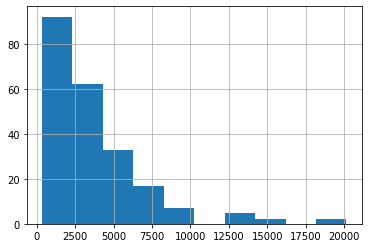

In [ ]:
with open(base_json, 'r') as f:
    resume_data = [json.loads(f_line) for f_line in f.readlines()]
    resume_df = pd.DataFrame([pop_annot(line) for line in resume_data])
resume_df['length'] = resume_df['content'].map(len)
resume_df['length'].hist()

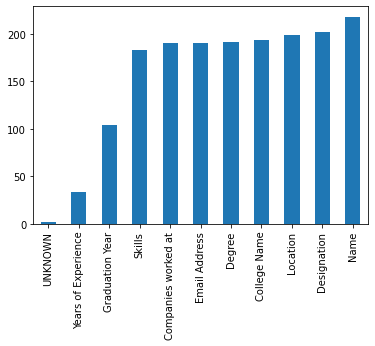

In [ ]:
resume_df.count()[3:-1].sort_values().plot(kind='bar')

In [ ]:
resume_df.sample(1)

,content,annotation,extras,Skills,College Name,Graduation Year,Designation,Companies worked at,Email Address,Location,Name,Degree,Years of Experience,UNKNOWN,length
168,Suresh Kanagala\nArchitecture SharePoint/Offic...,"[{'label': ['Skills'], 'points': [{'start': 11...",None,"[{'start': 1171, 'end': 1573, 'text': 'Operati...","[{'start': 925, 'end': 945, 'text': 'Nagarjuna...","[{'start': 947, 'end': 950, 'text': '1999'}, {...","[{'start': 273, 'end': 311, 'text': 'Senior Pr...","[{'start': 369, 'end': 372, 'text': 'IBM '}, {...","[{'start': 113, 'end': 158, 'text': 'indeed.co...","[{'start': 583, 'end': 591, 'text': 'Hyderabad...","[{'start': 0, 'end': 14, 'text': 'Suresh Kanag...","[{'start': 887, 'end': 922, 'text': 'B.Sc in M...",NaN,NaN,1616


In [ ]:
def process_data(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        raise e

In [ ]:
import re
def trim_spans(data):
    invalid_span_tokens = re.compile(r'\s')
    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

In [ ]:
data = trim_spans(process_data("Entity Recognition in Resumes.json"))

In [ ]:
tags_vals = ["UNKNOWN", "O", "Name", "Degree", "Skills", "College Name", "Email Address",
             "Designation", "Companies worked at", "Graduation Year", "Years of Experience", "Location"]

tag2idx = {t: i for i, t in enumerate(tags_vals)}
idx2tag = {i: t for i, t in enumerate(tags_vals)}

In [ ]:
!pip -q install tokenizers
!pip -q install transformers

     |████████████████████████████████| 3.2MB 1.8MB/s 
     |████████████████████████████████| 2.0MB 1.5MB/s 
     |████████████████████████████████| 890kB 10.2MB/s 


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import MODEL_FOR_TOKEN_CLASSIFICATION_MAPPING
from IPython.display import clear_output

In [ ]:
def convert_examples_to_features(data, tokenizer, max_len, is_test=False):
    def get_label(offset, labels):
        if offset[0] == 0 and offset[1] == 0:
            return 'O'
        for label in labels:
            if offset[1] >= label[0] and offset[0] <= label[1]:
                return label[2]
        return 'O'
    tok = tokenizer.encode_plus(
        data[0], 
        max_length=max_len, 
        truncation=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
        return_token_type_ids=True
    )
    curr_sent = {'orig_labels': [], 'labels': []}
    padding_length = max_len - len(tok['input_ids'])
    if not is_test:
        labels = data[1]['entities']
        labels.reverse()
        for off in tok['offset_mapping']:
            label = get_label(off, labels)
            curr_sent['orig_labels'].append(label)
            curr_sent['labels'].append(tag2idx[label])
        curr_sent['labels'] = curr_sent['labels'] + ([0] * padding_length)
    curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
    curr_sent['token_type_ids'] = tok['token_type_ids'] + \
        ([0] * padding_length)
    curr_sent['attention_mask'] = tok['attention_mask'] + \
        ([0] * padding_length)
    return curr_sent

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import (
    Dataset, DataLoader, 
    SequentialSampler, RandomSampler
)
from transformers import AutoConfig
from transformers import (
    get_cosine_schedule_with_warmup, 
    get_cosine_with_hard_restarts_schedule_with_warmup
)
from tqdm import tqdm, trange

In [ ]:
def get_special_tokens(tokenizer, tag2idx):
    vocab = tokenizer.get_vocab()
    pad_tok = vocab['<pad>']
    sep_tok = vocab['</s>']
    cls_tok = vocab['<s>']
    o_lab = tag2idx["O"]
    return pad_tok, sep_tok, cls_tok, o_lab

class DatasetRetriever(Dataset):
    def __init__(self, data, tokenizer, tag2idx, max_len, is_test=False):
        self.data = data
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.tag2idx = tag2idx
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        data = self.data[item]
        features = convert_examples_to_features(
            data, self.tokenizer, 
            self.max_len, self.is_test
        )
        return {
            'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
            'token_type_ids':torch.tensor(features['token_type_ids'], dtype=torch.long),
            'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
            'labels':torch.tensor(features['labels'], dtype=torch.long),
            # 'orig_label':features['orig_labels']
        }

In [ ]:
class TokenClassificationModel(nn.Module):
    def __init__(
        self, 
        model_name, 
        config, 
        add_pooling_layer=False, 
        multisample_dropout=True,
        output_hidden_states=False
    ):
        super(TokenClassificationModel, self).__init__()
        self.config = config
        self.roberta = AutoModel.from_pretrained(
            model_name, 
            add_pooling_layer=add_pooling_layer, 
            output_hidden_states=output_hidden_states
        )
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        if multisample_dropout:
            self.dropouts = nn.ModuleList([
                nn.Dropout(0.4) for _ in range(5)
            ])
        else:
            self.dropouts = nn.ModuleList([nn.Dropout(0.3)])
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self._init_weights(self.layer_norm)
        self._init_weights(self.classifier)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(
        self, 
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None
    ):
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        sequence_output = outputs[0] # batchsize, max_len, hhidden_size
        sequence_output = self.layer_norm(sequence_output) 

        # max-avg head
        # average_pool = torch.mean(sequence_output, 1)
        # max_pool, _ = torch.max(sequence_output, 1)
        # concat_sequence_output = torch.cat((average_pool, max_pool), 1)

        # multi-sample dropout
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                logits = self.classifier(dropout(sequence_output))
            else:
                logits += self.classifier(dropout(sequence_output))
        
        logits /= len(self.dropouts)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.config.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))
        
        output = (logits,) + outputs[2:]
        return ((loss,) + output) if loss is not None else output

In [ ]:
class Lamb(Optimizer):
    # Reference code: https://github.com/cybertronai/pytorch-lamb

    def __init__(
        self,
        params,
        lr: float = 1e-3,
        betas = (0.9, 0.999),
        eps: float = 1e-6,
        weight_decay: float = 0,
        clamp_value: float = 10,
        adam: bool = False,
        debias: bool = False,
    ):
        if lr <= 0.0:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if eps < 0.0:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                'Invalid beta parameter at index 0: {}'.format(betas[0])
            )
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                'Invalid beta parameter at index 1: {}'.format(betas[1])
            )
        if weight_decay < 0:
            raise ValueError(
                'Invalid weight_decay value: {}'.format(weight_decay)
            )
        if clamp_value < 0.0:
            raise ValueError('Invalid clamp value: {}'.format(clamp_value))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.clamp_value = clamp_value
        self.adam = adam
        self.debias = debias

        super(Lamb, self).__init__(params, defaults)

    def step(self, closure = None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    msg = (
                        'Lamb does not support sparse gradients, '
                        'please consider SparseAdam instead'
                    )
                    raise RuntimeError(msg)

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Paper v3 does not use debiasing.
                if self.debias:
                    bias_correction = math.sqrt(1 - beta2 ** state['step'])
                    bias_correction /= 1 - beta1 ** state['step']
                else:
                    bias_correction = 1

                # Apply bias to lr to avoid broadcast.
                step_size = group['lr'] * bias_correction

                weight_norm = torch.norm(p.data).clamp(0, self.clamp_value)

                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(p.data, alpha=group['weight_decay'])

                adam_norm = torch.norm(adam_step)
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio
                if self.adam:
                    trust_ratio = 1

                p.data.add_(adam_step, alpha=-step_size * trust_ratio)

        return loss

def get_optimizer_params(model):
    # differential learning rate and weight decay
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [param for name, param in model.roberta.named_parameters() if not any(nd in name for nd in no_decay)],
            'weight_decay': 0.001, 
            'lr':2e-5
        },
        {
            'params': [param for name, param in model.roberta.named_parameters() if any(nd in name for nd in no_decay)], 
            'weight_decay': 0.0, 
            'lr':2e-5
        },
        {
            'params': [param for name, param in model.named_parameters() if "roberta" not in name], 
            'lr':1e-3, 
            "momentum" : 0.99
        },
    ]
    return optimizer_grouped_parameters

In [ ]:
def make_model(model_name='roberta-base', num_labels=None):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(model_name)
    config.update({'num_labels':num_labels})
    model = TokenClassificationModel(model_name, config=config)
    return model, tokenizer

def make_optimizer(model, optimizer_name="LAMB"):
    optimizer_grouped_parameters = get_optimizer_params(model)
    kwargs = {
            'lr':2e-5,
            'weight_decay':0
    }
    if optimizer_name == "LAMB":
        optimizer = Lamb(optimizer_grouped_parameters, **kwargs)
        return optimizer
    elif optimizer_name == "Adam":
        from torch.optim import Adam
        optimizer = Adam(optimizer_grouped_parameters, **kwargs)
        return optimizer
    elif optimizer_name == "AdamW":
        from torch.optim import AdamW
        optimizer = AdamW(optimizer_grouped_parameters, **kwargs)
        return optimizer
    else:
        raise Exception('Unknown optimizer: {}'.format(optimizer_name))

def make_scheduler(optimizer, decay_name='cosine_warmup', t_max=10):
    if decay_name == 'step':
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[30, 60, 90],
            gamma=0.1
        )
    elif decay_name == 'cosine':
        scheduler = lrs.CosineAnnealingLR(
            optimizer,
            T_max=t_max
        )
    elif decay_name == "cosine_warmup":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=t_max
        )
    else:
        raise Exception('Unknown lr scheduler: {}'.format(decay_type))    
    return scheduler    

def make_loader(
    data, 
    tokenizer, 
    tag2idx, 
    max_len,
    batch_size,
):
    train_idx = int(len(data) * 0.9)
    train_set, valid_set = data[:train_idx], data[train_idx:]
    
    train_dataset = DatasetRetriever(train_set, tokenizer, tag2idx, max_len)
    valid_dataset = DatasetRetriever(valid_set, tokenizer, tag2idx, max_len)

    train_sampler = RandomSampler(train_dataset)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler, 
        pin_memory=True, 
        drop_last=True, 
        num_workers=0
    )

    valid_sampler = SequentialSampler(valid_dataset)
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size // 2, 
        sampler=valid_sampler, 
        pin_memory=False, 
        drop_last=False, 
        num_workers=0
    )

    return train_loader, valid_loader

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0
        self.min = 1e5

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        if val > self.max:
            self.max = val
        if val < self.min:
            self.min = val

def flat_accuracy(valid_tags, pred_tags):
    return (np.array(valid_tags) == np.array(pred_tags)).mean()

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, scalar=None, log_interval=2):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.scalar = scalar
        self.log_interval = log_interval

    def train(self, data_loader, epoch, result_dict, tokenizer, tag2idx):
        total_loss = 0
        count = 0
        
        pad_tok, sep_tok, cls_tok, o_lab = get_special_tokens(tokenizer, tag2idx)
        
        losses = AverageMeter()
        top1 = AverageMeter()

        self.model.train()
        
        for batch_idx, batch_data in enumerate(data_loader):
            input_ids, attention_mask, token_type_ids, labels = batch_data['input_ids'], \
                batch_data['attention_mask'], batch_data['token_type_ids'], batch_data['labels']
            input_ids, attention_mask, token_type_ids, labels = \
                input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda(), labels.cuda()

            
            if self.scalar is not None:
                with torch.cuda.amp.autocast():
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels
                    )
            else:
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    labels=labels
                )
            
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), 
                max_norm=1.0
            )

            loss, logits = outputs[:2]
            total_loss += loss.tolist()
            count += labels.size(0)
            
            preds_mask = (
                (input_ids != cls_tok)
                & (input_ids != pad_tok)
                & (input_ids != sep_tok)
            )

            logits = logits.cpu().detach().numpy()
            label_ids = torch.masked_select(labels, (preds_mask == 1))
            preds_mask = preds_mask.cpu().detach().numpy()
            
            batch_preds = np.argmax(logits[preds_mask.squeeze()], axis=1)
            batch_labels = label_ids.to("cpu").numpy()
            prec1 = flat_accuracy(batch_labels, batch_preds)

            losses.update(loss.item(), input_ids.size(0))
            top1.update(prec1.item(), input_ids.size(0))

            self.optimizer.zero_grad()
            if self.scalar is not None:
                self.scalar.scale(loss).backward()
                self.scalar.step(self.optimizer)
                self.scalar.update()
            else:
                loss.backward()
                self.optimizer.step()

            if batch_idx % self.log_interval == 0:
                _s = str(len(str(len(data_loader.sampler))))
                ret = [
                    ('epoch: {:0>3} [{: >' + _s + '}/{} ({: >3.0f}%)]').format(epoch, count, len(data_loader.sampler), 100 * count / len(data_loader.sampler)),
                    'train_loss: {: >4.2e}'.format(total_loss / count),
                    'train_accuracy : {:.2f}%'.format(top1.val)
                ]
                print(', '.join(ret))

        self.scheduler.step()
        result_dict['train_loss'].append(losses.avg)
        result_dict['train_acc'].append(top1.avg)
        return result_dict

In [ ]:
class Evaluator:
    def __init__(self, model, scalar=None):
        self.model = model
        self.scalar = scalar
    
    def worst_result(self):
        ret = {
            'loss':float('inf'),
            'accuracy':0.0
        }
        return ret

    def result_to_str(self, result):
        ret = [
            'epoch: {epoch:0>3}',
            'loss: {loss: >4.2e}'
        ]
        for metric in self.evaluation_metrics:
            ret.append('{}: {}'.format(metric.name, metric.fmtstr))
        return ', '.join(ret).format(**result)

    def save(self, result):
        with open('result_dict.json', 'w') as f:
            f.write(json.dumps(result, sort_keys=True, indent=4, ensure_ascii=False))
    
    def load(self):
        result = self.worst_result
        if os.path.exists('result_dict.json'):
            with open('result_dict.json', 'r') as f:
                try:
                    result = json.loads(f.read())
                except:
                    pass
        return result

    def evaluate(self, data_loader, epoch, result_dict, tokenizer, tag2idx):
        losses = AverageMeter()
        top1 = AverageMeter()

        pad_tok, sep_tok, cls_tok, o_lab = get_special_tokens(tokenizer, tag2idx)

        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_idx, batch_data in enumerate(data_loader):
                input_ids, attention_mask, token_type_ids, labels = batch_data['input_ids'], \
                    batch_data['attention_mask'], batch_data['token_type_ids'], batch_data['labels']
                input_ids, attention_mask, token_type_ids, labels = input_ids.cuda(), \
                    attention_mask.cuda(), token_type_ids.cuda(), labels.cuda()
                
                if self.scalar is not None:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            labels=labels
                        )
                else:
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels
                    )
                
                loss, logits = outputs[:2]

                preds_mask = (
                    (input_ids != pad_tok) &
                    (input_ids != sep_tok) &
                    (input_ids != cls_tok)
                )

                logits = logits.cpu().detach().numpy()
                label_ids = torch.masked_select(labels, (preds_mask == 1))
                preds_mask = preds_mask.cpu().detach().numpy()
                
                batch_preds = np.argmax(logits[preds_mask.squeeze()], axis=1)
                batch_labels = label_ids.to("cpu").numpy()
                prec1 = flat_accuracy(batch_labels, batch_preds)
                
                losses.update(loss.item(), input_ids.size(0))
                top1.update(prec1.item(), input_ids.size(0))

        print('----Validation Results Summary----')
        print('Epoch: [{}] Top-1 accuracy: {:.2f}%'.format(epoch, top1.avg))

        result_dict['val_loss'].append(losses.avg)
        result_dict['val_acc'].append(top1.avg)
        
        return result_dict

In [ ]:
torch.manual_seed(2021)
epochs = 15
max_len = 500
batch_size = 4

model, tokenizer = make_model(model_name='roberta-large', num_labels=len(tag2idx))
optimizer = make_optimizer(model, "AdamW")
scheduler = make_scheduler(optimizer, t_max=epochs)
train_loader, valid_loader = make_loader(
    data, tokenizer, 
    tag2idx, max_len=max_len,
    batch_size=batch_size
)

if torch.cuda.device_count() >= 1:
    print('Model pushed to {} GPU(s), type {}.'.format(
        torch.cuda.device_count(), 
        torch.cuda.get_device_name(0))
    )
    model = model.cuda() 
else:
    raise ValueError('CPU training is not supported')

scaler = torch.cuda.amp.GradScaler()

result_dict = {
    'epoch':[], 
    'train_loss' : [], 
    'train_acc' : [], 
    'val_loss' : [], 
    'val_acc' : [], 
    'test_acc':[]
}

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model pushed to 1 GPU(s), type Tesla T4.


In [ ]:
import time

trainer = Trainer(model, optimizer, scheduler, scaler)
evaluator = Evaluator(model, scaler)

train_time_list = []
valid_time_list = []

best_val_acc = 0.0

for epoch in range(epochs):
    result_dict['epoch'] = epoch

    torch.cuda.synchronize()
    tic1 = time.time()

    result_dict = trainer.train(train_loader, epoch, result_dict, tokenizer, tag2idx)

    torch.cuda.synchronize()
    tic2 = time.time() 
    train_time_list.append(tic2 - tic1)

    torch.cuda.synchronize()
    tic3 = time.time()

    result_dict = evaluator.evaluate(valid_loader, epoch, result_dict, tokenizer, tag2idx)

    torch.cuda.synchronize()
    tic4 = time.time() 
    valid_time_list.append(tic4 - tic3)

    if result_dict['val_acc'][-1] > best_val_acc:
        print("{} epoch, best epoch was updated! {}%".format(epoch, result_dict['val_acc'][-1]))
        best_val_acc = result_dict['val_acc'][-1]
        torch.save(model.state_dict(), "model.bin")

epoch: 000 [  4/198 (  2%)], train_loss: 8.44e-01, train_accuracy : 0.02%
epoch: 000 [ 12/198 (  6%)], train_loss: 8.86e-01, train_accuracy : 0.01%
epoch: 000 [ 20/198 ( 10%)], train_loss: 8.89e-01, train_accuracy : 0.02%
epoch: 000 [ 28/198 ( 14%)], train_loss: 8.65e-01, train_accuracy : 0.08%
epoch: 000 [ 36/198 ( 18%)], train_loss: 7.56e-01, train_accuracy : 0.80%
epoch: 000 [ 44/198 ( 22%)], train_loss: 6.72e-01, train_accuracy : 0.75%
epoch: 000 [ 52/198 ( 26%)], train_loss: 5.90e-01, train_accuracy : 0.92%
epoch: 000 [ 60/198 ( 30%)], train_loss: 5.64e-01, train_accuracy : 0.56%
epoch: 000 [ 68/198 ( 34%)], train_loss: 5.26e-01, train_accuracy : 0.85%
epoch: 000 [ 76/198 ( 38%)], train_loss: 4.89e-01, train_accuracy : 0.86%
epoch: 000 [ 84/198 ( 42%)], train_loss: 4.57e-01, train_accuracy : 0.88%
epoch: 000 [ 92/198 ( 46%)], train_loss: 4.32e-01, train_accuracy : 0.76%
epoch: 000 [100/198 ( 51%)], train_loss: 4.07e-01, train_accuracy : 0.87%
epoch: 000 [108/198 ( 55%)], train_los

No handles with labels found to put in legend.


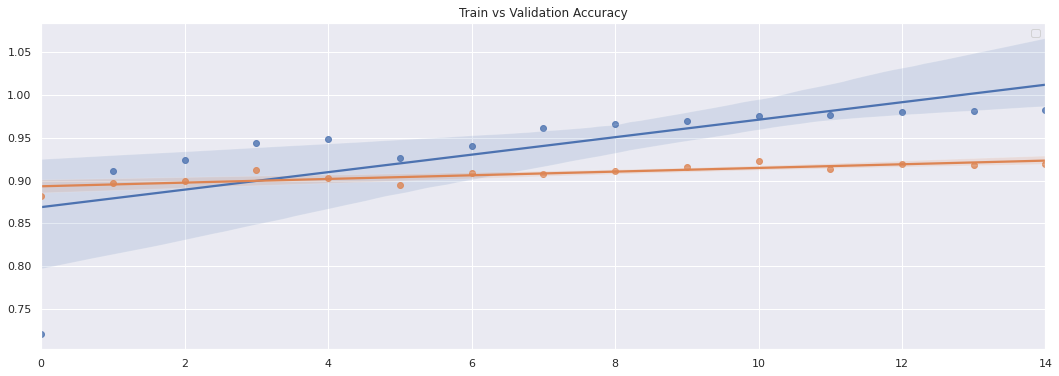

In [ ]:
import seaborn as sns; sns.set_theme(color_codes=True)
plt.figure(figsize=(18, 6))
sns.regplot(x=np.arange(0, len(result_dict['train_acc']), 1).tolist(), y=result_dict['train_acc'])
sns.regplot(x=np.arange(0, len(result_dict['val_acc']), 1).tolist(), y=result_dict['val_acc'])
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

No handles with labels found to put in legend.


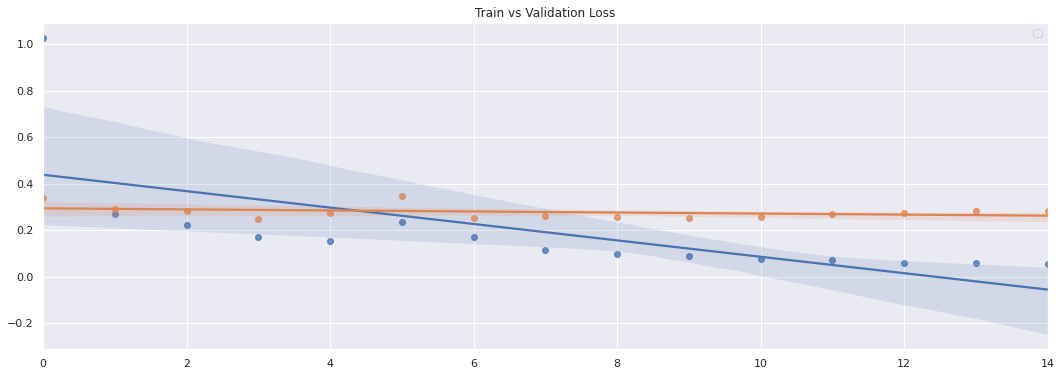

In [ ]:
plt.figure(figsize=(18, 6))
sns.regplot(x=np.arange(0, len(result_dict['train_loss']), 1).tolist(), y=result_dict['train_loss'])
sns.regplot(x=np.arange(0, len(result_dict['val_loss']), 1).tolist(), y=result_dict['val_loss'])
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
print(f'Average Training Time {np.mean(train_time_list):.2f} secs.')
print(f'Average Validation Time {np.mean(valid_time_list):.2f} secs.')
print()
print(f'Total Training Time for {epochs} epochs is {np.sum(train_time_list):.2f} secs.')
print(f'Total Validation Time for {epochs} epochs is {np.sum(valid_time_list):.2f} secs.')

Average Training Time 37.13 secs.
Average Validation Time 1.27 secs.

Total Training Time for 15 epochs is 557.02 secs.
Total Validation Time for 15 epochs is 19.10 secs.


## Inference

In [ ]:

def preprocess_data(data):
    text = extract_text(data)
    text = text.replace("\n", " ")
    text = text.replace("\f", " ")
    return text

def tokenize_resume(text, tokenizer, max_len):
    tok = tokenizer.encode_plus(
        text, 
        max_length=max_len, 
        return_offsets_mapping=True,
        return_token_type_ids=True
    )

    curr_sent = dict()

    padding_length = max_len - len(tok['input_ids'])

    curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
    curr_sent['token_type_ids'] = tok['token_type_ids'] + \
        ([0] * padding_length)
    curr_sent['attention_mask'] = tok['attention_mask'] + \
        ([0] * padding_length)

    final_data = {
        'input_ids': torch.tensor(curr_sent['input_ids'], dtype=torch.long),
        'token_type_ids': torch.tensor(curr_sent['token_type_ids'], dtype=torch.long),
        'attention_mask': torch.tensor(curr_sent['attention_mask'], dtype=torch.long),
        'offset_mapping': tok['offset_mapping']
    }

    return final_data

tags_vals = ["UNKNOWN", "O", "Name", "Degree", "Skills", "College Name", "Email Address",
             "Designation", "Companies worked at", "Graduation Year", "Years of Experience", "Location"]
idx2tag = {i: t for i, t in enumerate(tags_vals)}
resticted_lables = ["UNKNOWN", "O", "Email Address"]


def predict(model, tokenizer, idx2tag, test_resume, max_len):
    model.eval()
    data = tokenize_resume(test_resume, tokenizer, max_len)
    input_ids, attention_mask, token_type_ids = data['input_ids'].unsqueeze(
        0), data['attention_mask'].unsqueeze(0), data['token_type_ids'].unsqueeze(0)
    labels = torch.tensor([1] * input_ids.size(0),
                          dtype=torch.long).unsqueeze(0)

    input_ids = input_ids.cuda()
    attention_mask = attention_mask.cuda()
    token_type_ids = token_type_ids.cuda()
    labels = labels.cuda()

    with torch.no_grad():
        outputs = model(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        tmp_eval_loss, logits = outputs[:2]

    logits = logits.cpu().detach().numpy()
    label_ids = np.argmax(logits, axis=2)

    entities = []
    for label_id, offset in zip(label_ids[0], data['offset_mapping']):
        curr_id = idx2tag[label_id]
        curr_start = offset[0]
        curr_end = offset[1]
        if curr_id not in resticted_lables:
            if len(entities) > 0 and entities[-1]['entity'] == curr_id and curr_start - entities[-1]['end'] in [0, 1]:
                entities[-1]['end'] = curr_end
            else:
                entities.append(
                    {'entity': curr_id, 'start': curr_start, 'end': curr_end})
    for ent in entities:
        ent['text'] = test_resume[ent['start']:ent['end']]
    return entities

In [ ]:
model.load_state_dict(
    torch.load("model.bin")
)
model.cuda()

TokenClassificationModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (La

In [ ]:
from google.colab import files
files.upload()

!pip -q install pdfminer.six
from pdfminer.high_level import extract_text

Saving rohit.pdf to rohit.pdf


In [ ]:
!unzip JavaSet\ 4.zip

Archive:  JavaSet 4.zip
  inflating: JavaSet 4/OmkarRajaramChorghe_ Core Java.pdf  
  inflating: JavaSet 4/ParshottamTyagi.docx  
  inflating: JavaSet 4/payalDotsharma1909@gmailDotcom.docx  
  inflating: JavaSet 4/PoojaPatil[5_1].pdf  
  inflating: JavaSet 4/Prabhat Kumar Singh.docx  
  inflating: JavaSet 4/Prince.pdf    
  inflating: JavaSet 4/priyanka.pdf  
  inflating: JavaSet 4/Rais Pal_Core Java.pdf  
  inflating: JavaSet 4/Raj K Pachauri.doc  
  inflating: JavaSet 4/rajDotcsDotbtech@gmailDotcom.doc  
  inflating: JavaSet 4/Rajendra_Jajra_RJ07.pdf  
  inflating: JavaSet 4/RamanandYadav[5_6].docx  
  inflating: JavaSet 4/RasmirekhaGiri[7_0].docx  
  inflating: JavaSet 4/RaviGupta[6_0].pdf  
  inflating: JavaSet 4/RaviShankarKumar[7_0].doc  
  inflating: JavaSet 4/Reema Joshi.docx  
  inflating: JavaSet 4/Resume _Reetalika.pdf  
  inflating: JavaSet 4/Resume.pdf    
  inflating: JavaSet 4/Resume_Ankit_new1 (1).docx  
  inflating: JavaSet 4/Resume_Gaurav_5 5yrs.docx  
  inflating: Ja

In [ ]:
files = os.listdir("JavaSet 4/")

In [ ]:
from glob import glob
files = glob("JavaSet 4/*.pdf")

In [ ]:
data = f"rohit.pdf"
text = preprocess_data(data)
entities = predict(model, tokenizer, idx2tag, text, max_len)
from pprint import pprint
pprint(entities)

[{'end': 11, 'entity': 'Name', 'start': 0, 'text': 'Rohit Singh'},
 {'end': 532, 'entity': 'Skills', 'start': 516, 'text': 'Machine Learning'},
 {'end': 547, 'entity': 'Skills', 'start': 534, 'text': 'Deep Learning'},
 {'end': 571,
  'entity': 'Skills',
  'start': 549,
  'text': 'Reinforcement Learning'},
 {'end': 588, 'entity': 'Skills', 'start': 573, 'text': 'Computer Vision'},
 {'end': 596, 'entity': 'Skills', 'start': 590, 'text': 'Python'},
 {'end': 608, 'entity': 'Skills', 'start': 598, 'text': 'TensorFlow'},
 {'end': 637, 'entity': 'Skills', 'start': 635, 'text': 'as'},
 {'end': 643, 'entity': 'Skills', 'start': 641, 'text': 'Sy'},
 {'end': 650, 'entity': 'Skills', 'start': 647, 'text': 'C++'},
 {'end': 653, 'entity': 'Skills', 'start': 652, 'text': 'C'},
 {'end': 664, 'entity': 'Skills', 'start': 655, 'text': 'Angular 8'},
 {'end': 670, 'entity': 'Skills', 'start': 666, 'text': 'Java'},
 {'end': 678, 'entity': 'Skills', 'start': 672, 'text': 'Spring'},
 {'end': 689, 'entity': '

In [ ]:
from transformers import MODEL_FOR_TOKEN_CLASSIFICATION_MAPPING

In [ ]:
[i for i in MODEL_FOR_TOKEN_CLASSIFICATION_MAPPING.keys()]

[transformers.models.convbert.configuration_convbert.ConvBertConfig,
 transformers.models.layoutlm.configuration_layoutlm.LayoutLMConfig,
 transformers.models.distilbert.configuration_distilbert.DistilBertConfig,
 transformers.models.camembert.configuration_camembert.CamembertConfig,
 transformers.models.flaubert.configuration_flaubert.FlaubertConfig,
 transformers.models.xlm.configuration_xlm.XLMConfig,
 transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig,
 transformers.models.longformer.configuration_longformer.LongformerConfig,
 transformers.models.roberta.configuration_roberta.RobertaConfig,
 transformers.models.squeezebert.configuration_squeezebert.SqueezeBertConfig,
 transformers.models.bert.configuration_bert.BertConfig,
 transformers.models.mobilebert.configuration_mobilebert.MobileBertConfig,
 transformers.models.xlnet.configuration_xlnet.XLNetConfig,
 transformers.models.albert.configuration_albert.AlbertConfig,
 transformers.models.electra.configuratio